# totalVI Tutorial

totalVI is an end-to-end framework for CITE-seq data. With totalVI, we can currently produce a joint latent representation of cells, denoised data for both protein and mRNA, and harmonize datasets. A test for differential expression of proteins is in the works. Here we demonstrate how to run totalVI on PBMC10k, a dataset of peripheral blood mononuclear cells publicly available from 10X Genomics with 17 proteins. We note that three proteins are control proteins so we remove them before running totalVI.



In [1]:
# The next cell is some code we use to keep the notebooks tested.
# Feel free to ignore!

In [2]:
def allow_notebook_for_test():
    print("Testing the totalVI notebook")

show_plot = True
test_mode = False
n_epochs_all = None
save_path = "data/"

if not test_mode:
    save_path = "../../data"

## Imports and data loading

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import anndata
import os

from scvi.dataset import Dataset10X
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [4]:
dataset = Dataset10X(
    dataset_name="pbmc_10k_protein_v3",
    save_path=os.path.join(save_path, "10X"),
    measurement_names_column=1,
    dense=True,
)

[2019-11-14 11:26:47,804] INFO - scvi.dataset.dataset | File /data/yosef2/users/adamgayoso/software/scVI/data/10X/pbmc_10k_protein_v3/filtered_feature_bc_matrix.tar.gz already downloaded
[2019-11-14 11:26:47,805] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2019-11-14 11:27:21,663] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2019-11-14 11:27:23,616] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-11-14 11:27:23,620] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-11-14 11:27:24,037] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-11-14 11:27:24,453] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells


To load from an AnnData object with `"protein_expression"` `obsm` and `"protein_names"` `uns`

```
from scvi.dataset import AnnDatasetFromAnnData, CellMeasurement

anndataset = anndata.read(save_path + "filename.h5ad")
dataset = AnnDatasetFromAnnData(ad=anndataset)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"],
)
dataset.initialize_cell_measurement(protein_data)
```

In general, protein data can be added to any `GeneExpressionDataset` through the `.initialize_cell_measurement(.)` method as shown above.

In [5]:
# We do some light filtering for cells without many genes expressed and cells with low protein counts
def filter_dataset(dataset):
    high_count_genes = (dataset.X > 0).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=5000, mode="seurat")

    # Filter control proteins
    non_control_proteins = []
    for i, p in enumerate(dataset.protein_names):
        if not p.startswith("IgG"):
            non_control_proteins.append(i)
        else:
            print(p)
    dataset.protein_expression = dataset.protein_expression[:, non_control_proteins]
    dataset.protein_names = dataset.protein_names[non_control_proteins]
    
    
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 200
    high_protein_cells = dataset.protein_expression.sum(axis=1) >= np.percentile(dataset.protein_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_protein_cells)
    dataset.update_cells(inds_to_keep)
    return dataset, inds_to_keep

In [6]:
if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)

[2019-11-14 11:27:25,076] INFO - scvi.dataset.dataset | Downsampling from 33538 to 11272 genes
[2019-11-14 11:27:25,376] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-11-14 11:27:25,661] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-11-14 11:27:25,948] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-11-14 11:27:26,092] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells
[2019-11-14 11:27:26,094] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2019-11-14 11:27:28,530] INFO - scvi.dataset.dataset | Downsampling from 11272 to 5000 genes
[2019-11-14 11:27:28,646] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-11-14 11:27:28,773] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-11-14 11:27:28,902] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-11-14 11:27:28,972] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7865 cells
IgG2a_control_TotalSeqB
IgG1_control_TotalSeqB
IgG2b_control_TotalSeqB
[2019-11-14 11:27:29,081] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-11-14 11:27:29,147] INFO - scvi.dataset.dataset | Downsampled from 7865 to 7759 cells


## Prepare and run model

In [7]:
totalvae = TOTALVI(dataset.nb_genes, len(dataset.protein_names))
use_cuda = True
lr = 5e-3
# This weirdness is for our testing
n_epochs = 500 if n_epochs_all is None else n_epochs_all
# See early stopping documentation for explanation of parameters (trainer.py)
# Early stopping does not comply with our automatic notebook testing so we disable it when testing
# Early stopping is done with respect to the test set
if test_mode is False:
    early_stopping_kwargs = {
        "early_stopping_metric": "elbo",
        "save_best_state_metric": "elbo",
        "patience": 50,
        "threshold": 0,
        "reduce_lr_on_plateau": True,
        "lr_patience": 30,
        "lr_factor": 0.6,
        "posterior_class": TotalPosterior,
    }
else:
    early_stopping_kwargs = None
    
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.95,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [8]:
trainer.train(lr=lr, n_epochs=n_epochs)

[2019-11-14 11:32:08,651] INFO - scvi.inference.trainer | Reducing LR on epoch 242.
[2019-11-14 11:32:41,890] INFO - scvi.inference.trainer | Reducing LR on epoch 274.
[2019-11-14 11:33:04,478] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 50 epochs
[2019-11-14 11:33:04,479] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


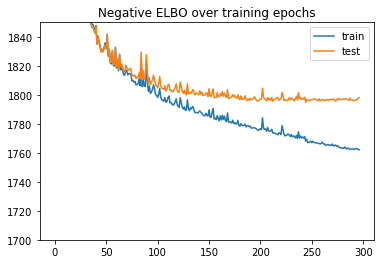

In [9]:
plt.plot(trainer.history["elbo_train_set"], label="train")
plt.plot(trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1700, 1850)
plt.legend()

## Analyze outputs

We use scanpy to do clustering, umap, visualization after running totalVI. The method `.sequential()` ensures that the ordering of outputs is the same as that in the dataset object.

In [10]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    totalvae, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 50
# Probability of background on logits scale, first dataset.nb_genes columns corresponds to ZI probability for genes
py_mixing = sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
)
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)
# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True
)

In [17]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.obsm["X_totalVI"] = latent_mean
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=20, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.3)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.7)

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/numba-0.45.0-py3.7-linux-x86_64.egg/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../.pyenv/versions/scvi/lib/python3.7/site-packages/umap_learn-0.3.10-py3.7.egg/umap/nndescent.py", line 46:
<source missing, REPL/exec in use?>

  self.func_ir.loc))


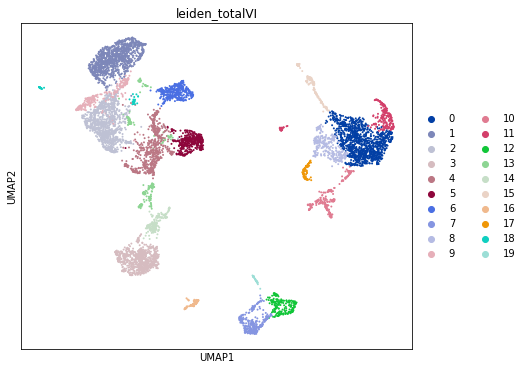

In [18]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(
    post_adata, 
    color=["leiden_totalVI"], 
    ax=ax, 
    show=show_plot
)

In [19]:
for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{}".format(p)] = denoised_proteins[:, i]

### Visualize denoised protein values 

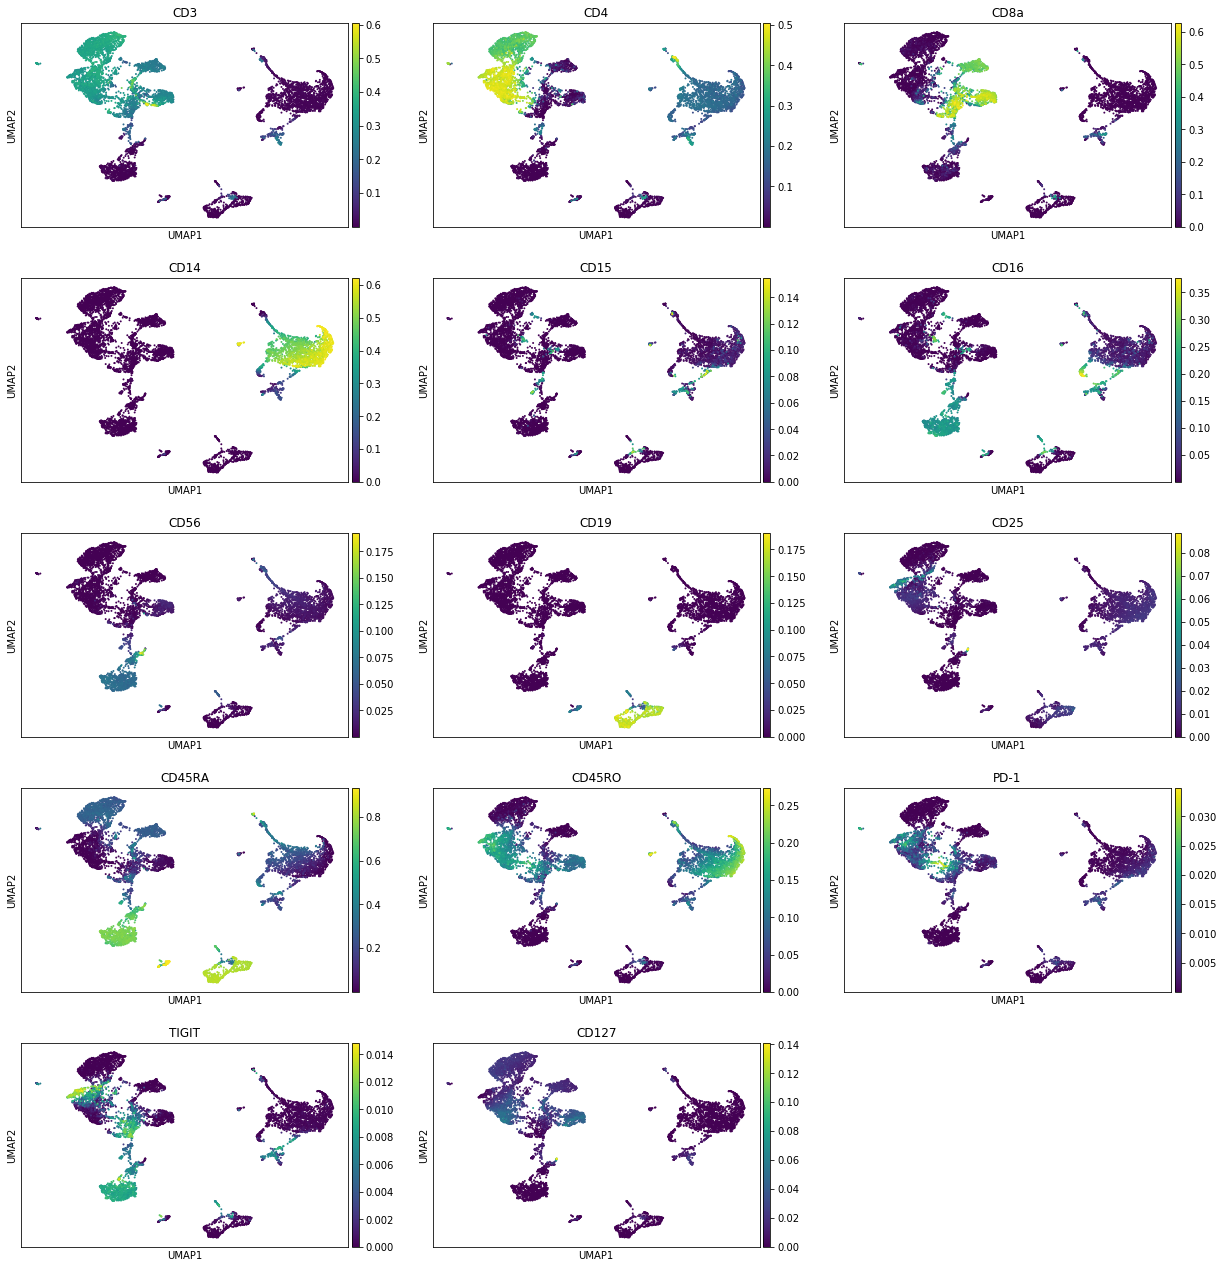

In [20]:
sc.pl.umap(
    post_adata, 
    color=parsed_protein_names, 
    ncols=3, 
    show=show_plot
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see no localization in the monocytes.

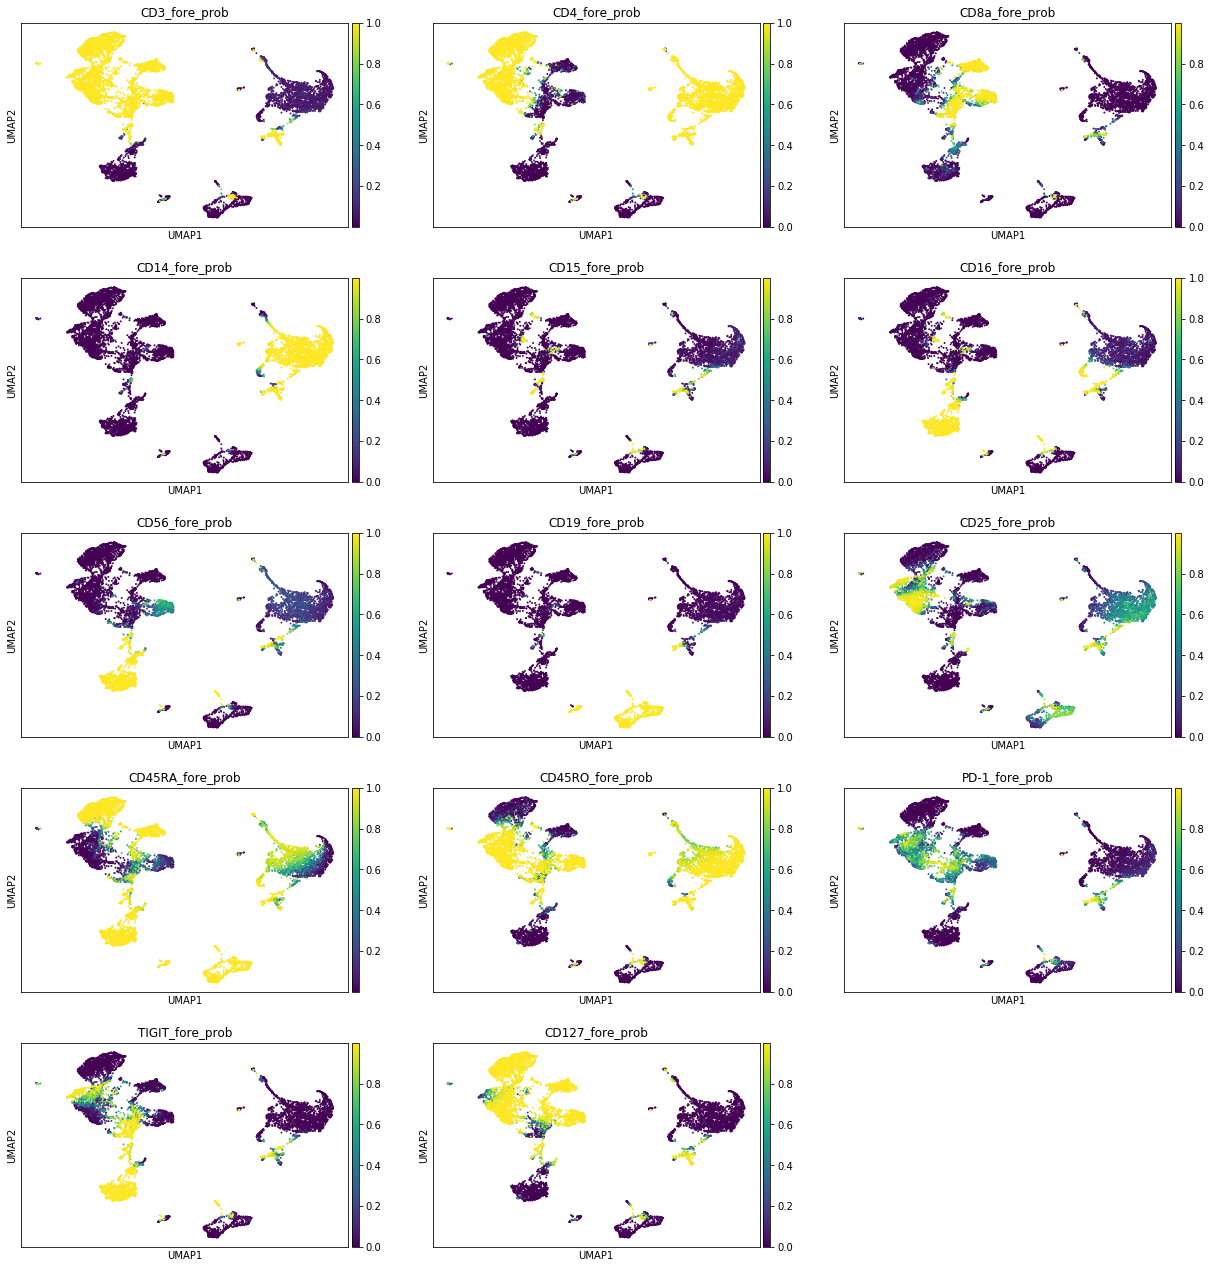

In [21]:
sc.pl.umap(
    post_adata,
    color=["{}_fore_prob".format(p) for p in parsed_protein_names],
    ncols=3,
    show=show_plot,
)

For example, CD25 appears to have a lot of overlap between background and foreground in the histogram of log UMI, which is why we see greater uncertainty in the respective CD25 UMAP above.

Text(0, 0.5, 'Number of cells')

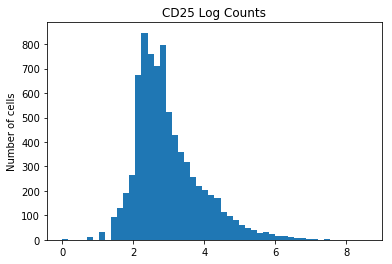

In [22]:
_ = plt.hist(
    np.log(
        dataset.protein_expression[
            :, np.where(dataset.protein_names == "CD25_TotalSeqB")[0]
        ]
        + 1
    ),
    bins=50,
)
plt.title("CD25 Log Counts")
plt.ylabel("Number of cells")